In [1]:
import numpy as np
import scipy as sc

In [2]:
# SU(2) QLM via SO(5) adjoint (10d) — corrected normalization & signs
# --------------------------------------------------------------------
# Raw access you get:
#   M_ab[(A,B)] : 10x10 Hermitian SO(5) generators (adjoint rep), 1<=A<B<=5
#   L[i], R[i]  : 10x10 SU(2)_L and SU(2)_R (i=0,1,2 ~ x,y,z)
#   U_mu[0..3]  : 10x10 Pauli-basis coefficients with U = U0⊗I + i Σ_k Uk⊗σ_k
#   U_full      : 20x20 link operator on (gauge ⊗ color)
#
# Tests:
#   - SU(2) algebras, [L_i,R_j]=0
#   - Full-space [L_i,U] = - (σ_i/2) U,  [R_i,U] = + U (σ_i/2)
#   - Component-level commutators for U_mu
#   - Hermiticity checks (these generators are Hermitian in this convention)

import numpy as np

# ---------- Utilities ----------
def I(n): return np.eye(n, dtype=np.complex128)
def comm(A,B): return A @ B - B @ A
def delta(a,b): return 1 if a==b else 0

def eps3(i,j,k):
    """Levi-Civita ε_{ijk} with i,j,k in {1,2,3} (1-based)."""
    if len({i,j,k}) < 3: return 0
    return 1 if (i,j,k) in [(1,2,3),(2,3,1),(3,1,2)] else -1

# ---------- 10-d adjoint basis for so(5) ----------
pairs = [(1,2),(1,3),(1,4),(1,5),
         (2,3),(2,4),(2,5),
         (3,4),(3,5),
         (4,5)]
pair_to_idx = {p:k for k,p in enumerate(pairs)}

def M_generator(A,B):
    """Hermitian adjoint-rep generator M_{AB} (10x10), with:
       [M_AB, M_CD] = i( δ_AC M_BD - δ_AD M_BC - δ_BC M_AD + δ_BD M_AC )."""
    if A==B: raise ValueError("A!=B required")
    if A>B: A,B = B,A
    dim = 10
    M = np.zeros((dim,dim), dtype=np.complex128)

    for (C,D), col in pair_to_idx.items():
        def add(coeff, X, Y):
            if X==Y: return
            s = 1
            if X>Y:
                X, Y = Y, X
                s = -1          # antisymmetry sign for reordering
            row = pair_to_idx[(X, Y)]
            M[row, col] += coeff * s

        add(1j*(A==C), B, D)
        add(-1j*(A==D), B, C)
        add(-1j*(B==C), A, D)
        add(1j*(B==D), A, C)

    return M

# All raw SO(5) generators
M_ab = {(a,b): M_generator(a,b) for a in range(1,6) for b in range(a+1,6)}

def M_symbolic(X,Y):
    """Return the generator with antisymmetry: M_{XY} = -M_{YX}."""
    if X==Y:
        return np.zeros((10,10), dtype=np.complex128)
    s = 1
    if X>Y:
        X, Y = Y, X
        s = -1
    return s * M_ab[(X,Y)]

# ---------- SU(2)_L × SU(2)_R inside SO(4) ⊂ SO(5) ----------
# Correct (self/anti-self-dual) split:
#   L_i = 1/2( M_{i4} + 1/2 ε_{ijk}M_{jk} ),   R_i = 1/2( -M_{i4} + 1/2 ε_{ijk}M_{jk} )
def build_LR():
    L = []
    R = []
    for i in (1,2,3):
        Mi4 = M_ab[(min(i,4), max(i,4))]
        eps_sum = np.zeros_like(Mi4)
        for j in (1,2,3):
            for k in (1,2,3):
                e = eps3(i,j,k)
                if e:
                    eps_sum += e * M_symbolic(j,k)
        Li = 0.5 * ( Mi4 + 0.5*eps_sum )
        Ri = 0.5 * ( -Mi4 + 0.5*eps_sum )
        L.append(Li); R.append(Ri)
    return L, R

L, R = build_LR()

# ---------- Pauli basis ----------
sigma0 = I(2)
sigma1 = np.array([[0,1],[1,0]], dtype=np.complex128)
sigma2 = np.array([[0,-1j],[1j,0]], dtype=np.complex128)
sigma3 = np.array([[1,0],[0,-1]], dtype=np.complex128)
sigma = [sigma0, sigma1, sigma2, sigma3]

# ---------- U decomposition with +i convention ----------
# U = U0 ⊗ σ0 + i Σ_{k=1}^3 U_k ⊗ σ_k,   U0=M45, Uk=M(k5)
U_mu = [None]*4
U_mu[0] = M_ab[(4,5)]
U_mu[1] = M_ab[(1,5)]
U_mu[2] = M_ab[(2,5)]
U_mu[3] = M_ab[(3,5)]

U_full = np.kron(U_mu[0], sigma0)
for k in (1,2,3):
    U_full += 1j * np.kron(U_mu[k], sigma[k])

# ---------- Lift L,R to gauge⊗color ----------
L_big = [np.kron(Li, I(2)) for Li in L]
R_big = [np.kron(Ri, I(2)) for Ri in R]
sigma_big = [np.kron(I(10), s) for s in (sigma1, sigma2, sigma3)]

# ---------- Pauli-coefficient projector (for +i convention) ----------
# If U = U0⊗I + i Σ_k Uk⊗σ_k, then:
#   U0 = (1/2) Tr_c[U],   Uk = (1/(2i)) Tr_c[(I⊗σ_k) U] = -(i/2) Tr_c[(I⊗σ_k) U]
def project_pauli_coeffs_plus_i(U20):
    U4 = U20.reshape(10,2,10,2)  # (g,c,g',c')
    def ptr(C):
        # ∑_{c,c'} U[g,c,g',c'] C[c',c]
        return np.tensordot(U4, C.T, axes=([1,3],[0,1]))
    U0 = 0.5 * ptr(sigma0)
    U1 = -(1j/2) * ptr(sigma1)
    U2 = -(1j/2) * ptr(sigma2)
    U3 = -(1j/2) * ptr(sigma3)
    return [U0, U1, U2, U3]

# Sanity: reconstruct coefficients from U_full
U_proj = project_pauli_coeffs_plus_i(U_full)
print("Pauli decomposition (projection) check: max error",
      f"{max(np.linalg.norm(U_proj[mu] - U_mu[mu], 2) for mu in range(4)):.2e}")

# ---------- Tests ----------
def test_su2_algebra(set3, name="X"):
    worst = 0.0
    for i in range(3):
        for j in range(3):
            lhs = comm(set3[i], set3[j])
            rhs = 1j * sum(eps3(i+1,j+1,k+1)*set3[k] for k in range(3))
            worst = max(worst, np.linalg.norm(lhs - rhs, 2))
    print(f"SU(2) algebra for {name}: max error {worst:.2e}")
    return worst

def test_LR_commute(Lset, Rset):
    worst = 0.0
    for i in range(3):
        for j in range(3):
            worst = max(worst, np.linalg.norm(comm(Lset[i], Rset[j]), 2))
    print(f"[L_i, R_j] = 0: max error {worst:.2e}")
    return worst

def test_U_transform_full(L_big, R_big, U_full):
    # Correct sign structure:
    #   [L_i, U] = -(σ_i/2) U
    #   [R_i, U] = + U (σ_i/2)
    worstL = 0.0; worstR = 0.0
    for i in range(3):
        lhs = comm(L_big[i], U_full)
        rhs = -0.5 * sigma_big[i] @ U_full
        worstL = max(worstL, np.linalg.norm(lhs - rhs, 2))

        lhs = comm(R_big[i], U_full)
        rhs = + U_full @ (0.5 * sigma_big[i])
        worstR = max(worstR, np.linalg.norm(lhs - rhs, 2))
    print(f"[L_i,U] + (σ_i/2)U: max error {worstL:.2e}")
    print(f"[R_i,U] − U(σ_i/2): max error {worstR:.2e}")
    return worstL, worstR

def test_U_transform_components_plus_i(L, R, U_mu):
    # Component identities (match the full relations above):
    #   L: [L_i,U0] = -(i/2) Ui
    #      [L_i,Um] =  (i/2)( δ_{im} U0 + ε_{imk} Uk )
    #   R: [R_i,U0] =  +(i/2) Ui
    #      [R_i,Um] = -(i/2)( δ_{im} U0 - ε_{imk} Uk )
    worstL = 0.0; worstR = 0.0
    for i in (1,2,3):
        worstL = max(worstL, np.linalg.norm(comm(L[i-1], U_mu[0]) + (1j/2)*U_mu[i], 2))
        worstR = max(worstR, np.linalg.norm(comm(R[i-1], U_mu[0]) - (1j/2)*U_mu[i], 2))
        for m in (1,2,3):
            rhs_L = (1j/2)*( delta(i,m)*U_mu[0] + sum(eps3(i,m,k)*U_mu[k] for k in (1,2,3)) )
            rhs_R = (-1j/2)*( delta(i,m)*U_mu[0] - sum(eps3(i,m,k)*U_mu[k] for k in (1,2,3)) )
            worstL = max(worstL, np.linalg.norm(comm(L[i-1], U_mu[m]) - rhs_L, 2))
            worstR = max(worstR, np.linalg.norm(comm(R[i-1], U_mu[m]) - rhs_R, 2))
    print(f"Component commutators — L: max error {worstL:.2e}, R: max error {worstR:.2e}")
    return worstL, worstR

def hermiticity_report():
    def H_norm(X): return np.linalg.norm(X - X.conj().T, 2)  # 0 iff Hermitian
    print(f"M_45 Hermiticity: ||M45−M45†|| = {H_norm(M_ab[(4,5)]):.2e}")
    print(f"L_i Hermiticity:  max ||L−L†||  = {max(H_norm(Li) for Li in L):.2e}")
    print(f"R_i Hermiticity:  max ||R−R†||  = {max(H_norm(Ri) for Ri in R):.2e}")
    print(f"U0 Hermitian?     ||U0−U0†||    = {H_norm(U_mu[0]):.2e}")
    print(f"Uk Hermitian? max ||Uk−Uk†||    = {max(H_norm(U_mu[k]) for k in (1,2,3)):.2e}")

# ---------- Run all tests ----------
_ = test_su2_algebra(L, name="L")
_ = test_su2_algebra(R, name="R")
_ = test_LR_commute(L, R)
_ = test_U_transform_full(L_big, R_big, U_full)
_ = test_U_transform_components_plus_i(L, R, U_mu)
hermiticity_report()

# ---------- RAW ACCESS (as requested) ----------
# M12 = M_ab[(1,2)]
L1, L2, L3 = L
R1, R2, R3 = R
U0, U1, U2, U3 = U_mu
# U20x20 = U_full

Pauli decomposition (projection) check: max error 0.00e+00
SU(2) algebra for L: max error 0.00e+00
SU(2) algebra for R: max error 0.00e+00
[L_i, R_j] = 0: max error 0.00e+00
[L_i,U] + (σ_i/2)U: max error 0.00e+00
[R_i,U] − U(σ_i/2): max error 0.00e+00
Component commutators — L: max error 0.00e+00, R: max error 0.00e+00
M_45 Hermiticity: ||M45−M45†|| = 0.00e+00
L_i Hermiticity:  max ||L−L†||  = 0.00e+00
R_i Hermiticity:  max ||R−R†||  = 0.00e+00
U0 Hermitian?     ||U0−U0†||    = 0.00e+00
Uk Hermitian? max ||Uk−Uk†||    = 0.00e+00


In [3]:
import scipy as sc

In [4]:
U00 = U0 + 1j*U3
U01 = U2 + 1j*U1
U10 = -U2 + 1j*U1
U11 = U0 -1j*U3

In [5]:
U = [[np.matrix(U00),np.matrix(U01)],[np.matrix(U10),np.matrix(U11)]]

U_dag = [[np.matrix(U00).H,np.matrix(U10).H],[np.matrix(U01).H,np.matrix(U11).H]]

In [6]:
res_00 = 0
res_11 = 0

for k1 in [0,1]:
    for k2 in [0,1]:
        for k3 in [0,1]:
            res_00 += np.kron(np.kron(np.kron(U[0][k1],U[k1][k2]),U_dag[k2][k3]),U_dag[k3][0])
            res_11 += np.kron(np.kron(np.kron(U[1][k1],U[k1][k2]),U_dag[k2][k3]),U_dag[k3][1])

In [7]:
H_mag = res_00 + res_00.H + res_11 + res_11.H

In [8]:
mat_el = np.matrix(L1@L1+L2@L2+L3@L3+R1@R1+R2@R2+R3@R3)

In [11]:
id = np.identity(10)

In [12]:
H_el = np.kron(np.kron(np.kron(mat_el,id),id),id)
H_el += np.kron(np.kron(np.kron(id,mat_el),id),id)
H_el += np.kron(np.kron(np.kron(id,id),mat_el),id)
H_el += np.kron(np.kron(np.kron(id,id),id),mat_el)

In [13]:
H_el_sparse = sc.sparse.coo_matrix(H_el)

In [14]:
H_mag_sparse = sc.sparse.coo_matrix(H_mag)

In [46]:
vals = []
g2 = np.linspace(0.1,10,100)
for i in g2:
    vals.append(sc.sparse.linalg.eigsh(i*H_el_sparse+1/i*H_mag_sparse, which="SA", k=32)[0])
    #vals.append(np.linalg.eigvalsh(i*H_el+1/i*H_mag))
    print(i)

vals = np.array(vals)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5000000000000004
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1
4.2
4.3
4.3999999999999995
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.700000000000001
9.8
9.9
10.0


In [47]:
for i in range(len(g2)):
    vals[i].sort()

In [51]:
import plaqTheory as p
p1x1 = np.empty((100,4))
for i in range(100):
    p1x1[i] = p.getGroundState(4/(g2[i]))

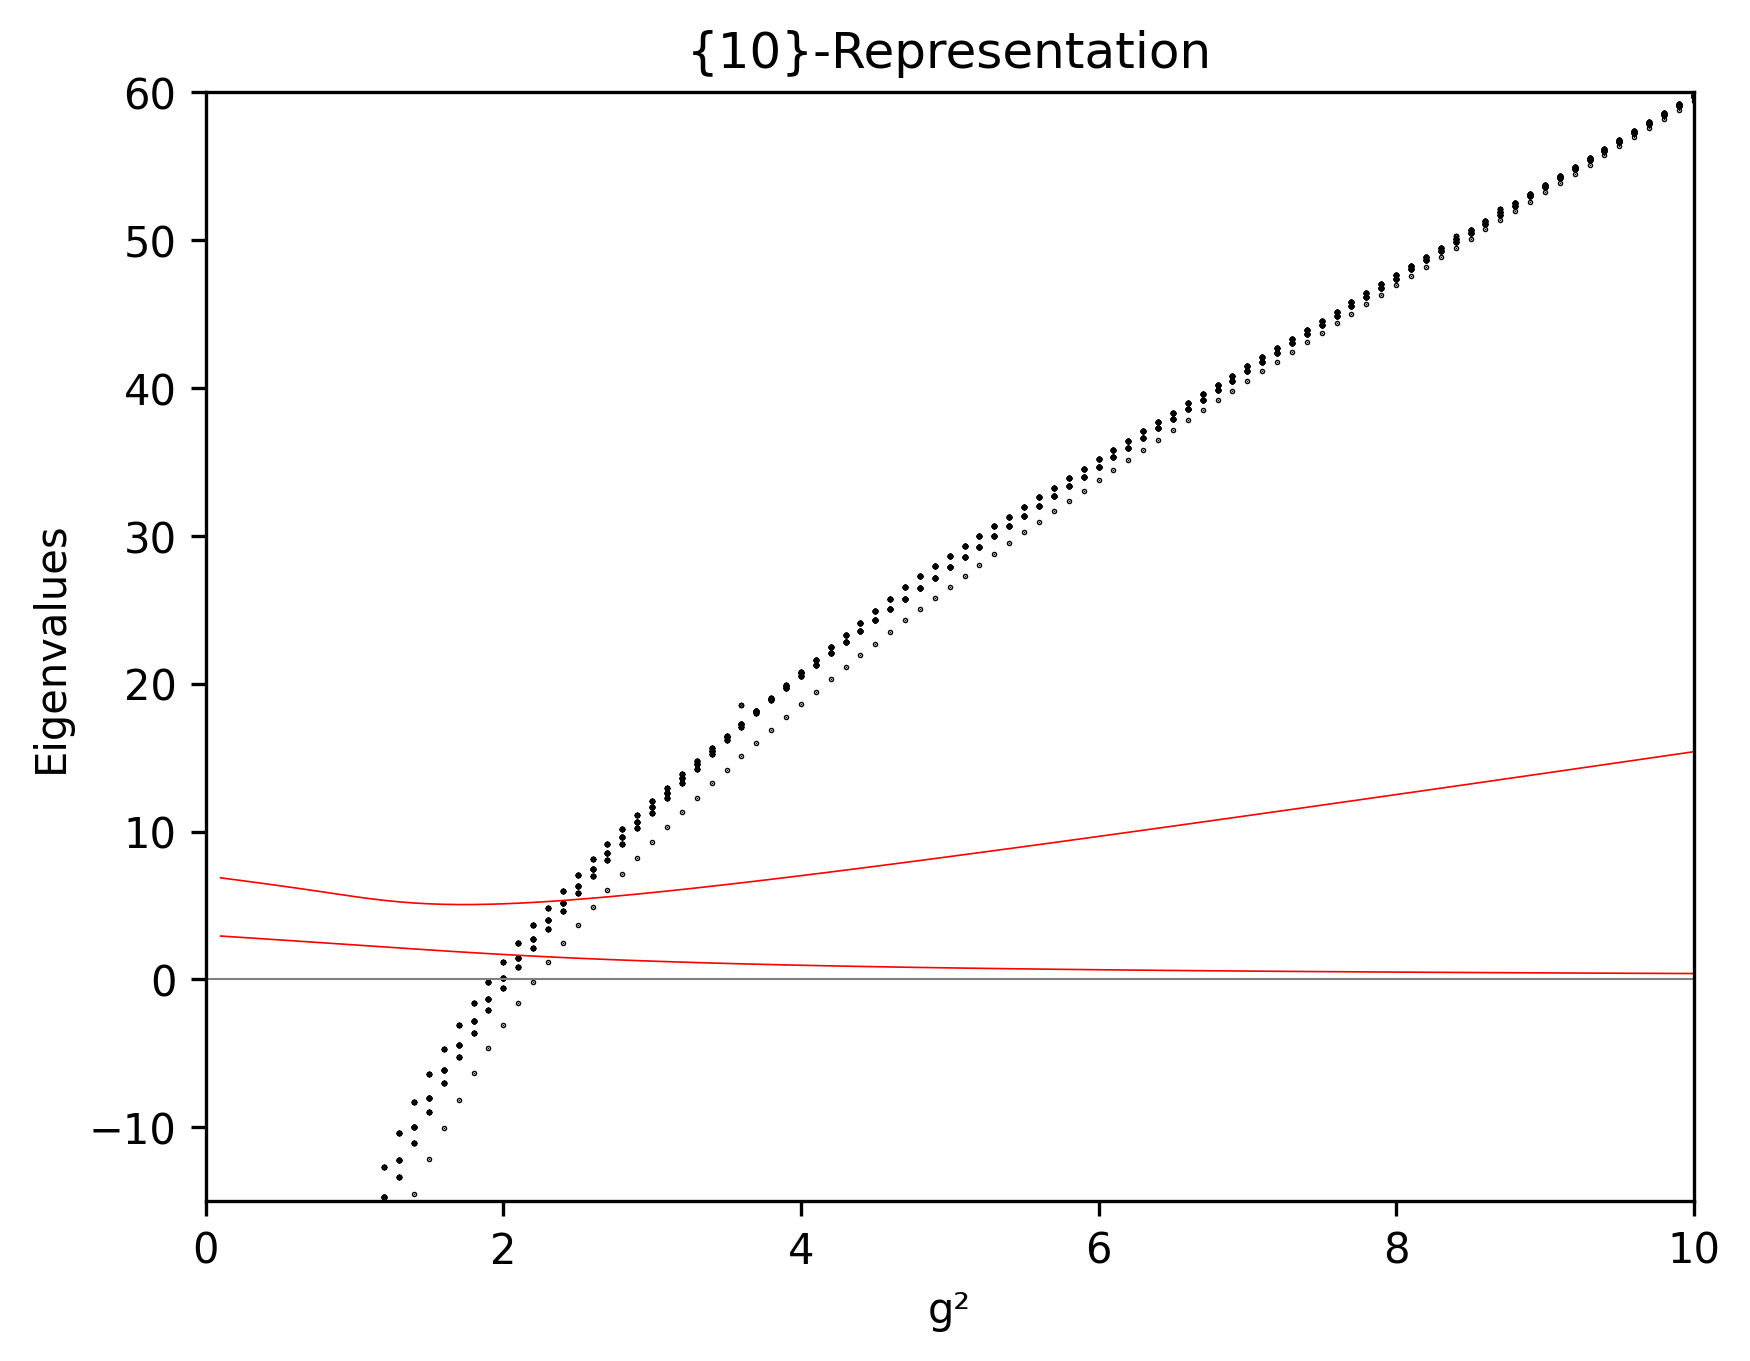

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
#fig.set_size_inches(12, 8)
fig.set_dpi(300)

for i in range(32):
    plt.scatter(g2, vals[:,i], color="black",s=0.11)#, linewidth="0.2")

plt.plot(g2,p1x1[:,0], color="red", linewidth="0.4")
plt.plot(g2,p1x1[:,0]+p1x1[:,2], color="red", linewidth="0.4")

#plt.hlines([2,-2], xmax=1, xmin=0, colors="black",linewidth=0.5)
plt.hlines(y=0,xmin=0,xmax=25, color="grey",linewidth=0.5)
plt.xlabel("g²")
plt.ylabel("Eigenvalues")
#plt.yscale("symlog")
plt.title("{10}-Representation")

plt.ylim(-15,60)
plt.xlim(0,10)

plt.savefig("plot_10rep.pdf", dpi=300)